In [14]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import groupby
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import nltk
import lightgbm as lgb

from utils import helper
from utils import DataLoader, DataProcesser

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

# Routine PipLines

In [3]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [4]:
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
val = DataLoader.SHLDataLoader('data/validate/', ratio = None)
data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [5]:
# tmp modeul
data.df['have_loc'] = data.df.apply(lambda x: 1 if x['accuracy'] > -1 else 0, axis = 1)
data.df['have_gps'] = data.df.apply(lambda x: 1 if x['num_gps'] > 0 else 0, axis = 1)
data.df['have_wifi'] = data.df.apply(lambda x: 1 if x['num_wifi'] > 0 else 0, axis = 1)
data.df['have_cells'] = data.df.apply(lambda x: 1 if x['num_cells'] > 0 else 0, axis = 1)

val.df['have_loc'] = val.df.apply(lambda x: 1 if x['accuracy'] > -1 else 0, axis = 1)
val.df['have_gps'] = val.df.apply(lambda x: 1 if x['num_gps'] > 0 else 0, axis = 1)
val.df['have_wifi'] = val.df.apply(lambda x: 1 if x['num_wifi'] > 0 else 0, axis = 1)
val.df['have_cells'] = val.df.apply(lambda x: 1 if x['num_cells'] > 0 else 0, axis = 1)

In [6]:
test_ratio = 0.2
col_label = 'label'
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
# X_train, X_test, y_train, y_test = train_test_split(X, data.df[col_label], test_size = test_ratio)
X_train, y_train = X, data.df[col_label]
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[col_label]

In [7]:
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)
pred_prob_rf = model_rf.predict_proba(X_val)

In [8]:
model_bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100, max_samples = 100, bootstrap=True)
model_bag.fit(X_train, y_train)
pred_bag = model_bag.predict(X_val)
pred_prob_bag = model_bag.predict_proba(X_val)

In [9]:
train_data = lgb.Dataset(X_train, label = y_train - 1)
test_data = lgb.Dataset(X_val, label = y_val - 1)
params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':6,
    'objective':'multiclass',
    'num_class':8,  
}
model_lgb = lgb.train(params, train_data, valid_sets = [test_data])
pred_prob_lgb = model_lgb.predict(X_val)
pred_lgb = pred_prob_lgb.argmax(axis = 1) + 1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5025
[LightGBM] [Info] Number of data points in the train set: 980527, number of used features: 36
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.081605
[LightGBM] [Info] Start training from score -2.077810
[LightGBM] [Info] Start training from score -3.143871
[LightGBM] [Info] Start training from score -2.122478
[LightGBM] [Info] Start training from

In [44]:
plt.style.use('seaborn-paper')

In [106]:
def plot_box(y, pred):
    plt.figure(figsize = [12, 10])
    sns.heatmap(confusion_matrix(y, pred), cmap = 'Blues', annot = True, fmt = 'd', xticklabels = list(label_dic.values()),
    yticklabels = list(label_dic.values()))

In [35]:
# helper.evaluate(y_val, pred_bag, normalize=False)

---
# Post Process - Discrete

In [106]:
# pred = pd.Series(pred_rf)
# pred_prob = pred_prob_rf

In [40]:
def get_pred_mode(sr):
    ct = Counter(sr).most_common()[0]
    return ct[0] if ct[1] >= 2 else sr[2]

df_res = pd.DataFrame({"rf": pred_rf, "bag": pred_bag, "lgb": pred_lgb})
df_res['pred'] = df_res.apply(lambda x: get_pred_mode(x[['rf', 'bag', 'lgb']]), axis = 1)
df_res['pred_mode'] = df_res['pred'].rolling(90, center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')

In [41]:
pred = df_res['pred_mode']

In [113]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label st

In [121]:
def plot_prediction(y_true, y_pred):
    plt.figure(figsize = [20, 10])
    plt.plot(y_pred, alpha = 0.7, c = 'steelblue', linewidth = 1.1, label = 'Prediction')
    plt.plot(y_true, c = 'black', label = 'Label')
    plt.legend(['Prediction', 'Label'], fontsize = 'x-large', bbox_to_anchor=(1.01, 0.5), loc=3, borderaxespad=0)
    plt.yticks(range(1, 9), list(label_dic.values()))
    plt.xlabel("Timestamps")

In [80]:
plt.style.use('seaborn-white')
# plot_prediction(y_val, pred)

In [81]:
# helper.evaluate(pred, y_val)

---
# Post Process - Continuous

- Add + mean + argmax
- Mean + add + argmax

In [82]:
window_size = 120

In [110]:
# Add + mean + argmax
pred_prob = pred_prob_rf + pred_prob_bag + pred_prob_lgb
pred_prob_mean = pred_prob
# pred_prob_mean = pd.DataFrame(pred_prob).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_mean = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[18342  6801    11    87    13   285   927  3370]
 [ 4091 17624   117   537   194  1583   889  1114]
 [    8   820   579  1325     5    30     3     4]
 [  256   760  1146  8460     8    14    15  1372]
 [  374   298     2  1223 10193  4886  3281   216]
 [  769    72     0   234    57  5041  1180  1825]
 [ 3494    54     0   118  4143   639 12645   715]
 [  559   412     0    11   375   194  5149 15009]]
              precision    recall  f1-score   support

       Still       0.66      0.61      0.64     29836
     Walking       0.66      0.67      0.67     26149
         Run       0.31      0.21      0.25      2774
        Bike       0.71      0.70      0.70     12031
         Car       0.68      0.50      0.57     20473
         Bus       0.40      0.55      0.46      9178
       Train       0.52      0.58      0.55     21808
      Subway       0.64      0.69      0.66     21709

    accuracy                           0.61    143958
   macro avg       0.57      0.56      0.56    14

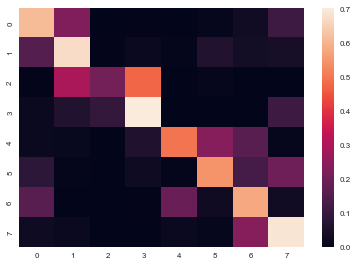

In [126]:
helper.evaluate(y_val, pred_mean)

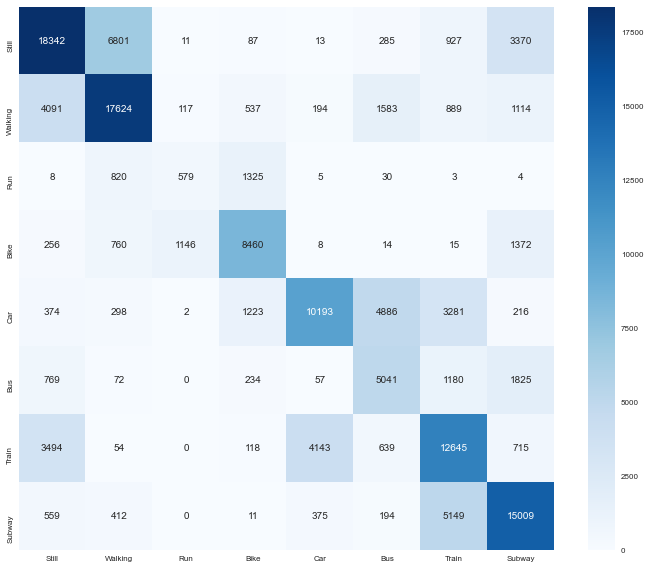

In [111]:
plot_box(y_val, pred_mean)

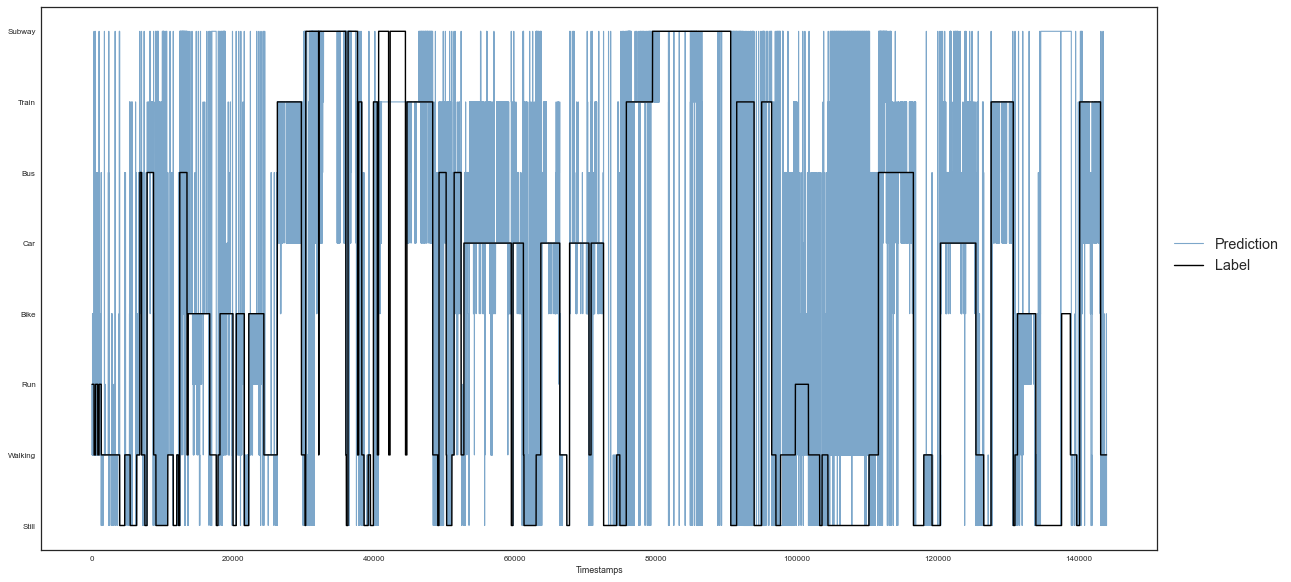

In [122]:
plot_prediction(y_val, pred_mean)

In [92]:
# helper.evaluate(y_val, pred_mean)

In [107]:
# Mean + add + argmax
pred_prob_rf_mean = pd.DataFrame(pred_prob_rf).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_prob_bag_mean = pd.DataFrame(pred_prob_bag).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_prob_lgb_mean = pd.DataFrame(pred_prob_lgb).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')

pred_prob_mean = pred_prob_rf_mean + pred_prob_bag_mean + pred_prob_lgb_mean
pred_mean2 = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[19178  6573     0    27    14    46   751  3247]
 [ 3122 19450     8    47   246  1575   695  1006]
 [    0  1039   460  1275     0     0     0     0]
 [  139   571   347  9729     0     0     0  1245]
 [  436   315     0   619 10681  5122  3240    60]
 [  800    23     0    30     0  5158  1054  2113]
 [ 3539    47     0    34  4195   235 13171   587]
 [  582   472     0     0   222    52  4886 15495]]
              precision    recall  f1-score   support

       Still       0.69      0.64      0.67     29836
     Walking       0.68      0.74      0.71     26149
         Run       0.56      0.17      0.26      2774
        Bike       0.83      0.81      0.82     12031
         Car       0.70      0.52      0.60     20473
         Bus       0.42      0.56      0.48      9178
       Train       0.55      0.60      0.58     21808
      Subway       0.65      0.71      0.68     21709

    accuracy                           0.65    143958
   macro avg       0.64      0.60      0.60    14

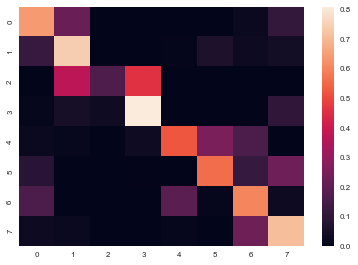

In [125]:
helper.evaluate(y_val, pred_mean2)

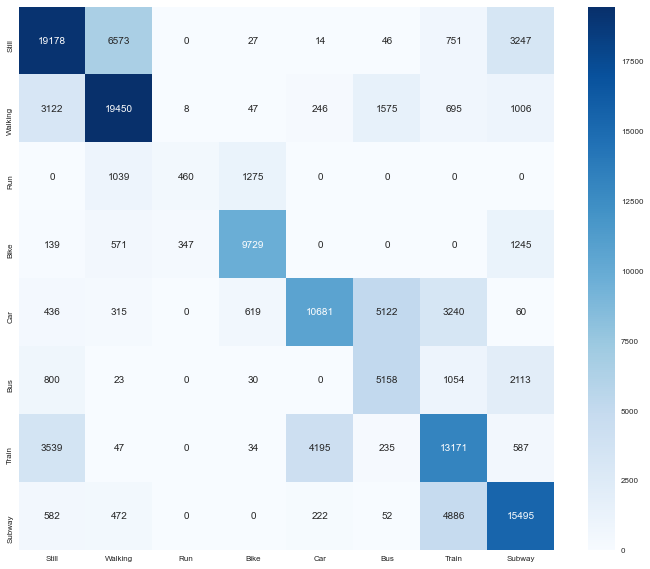

In [124]:
plot_box(y_val, pred_mean2)

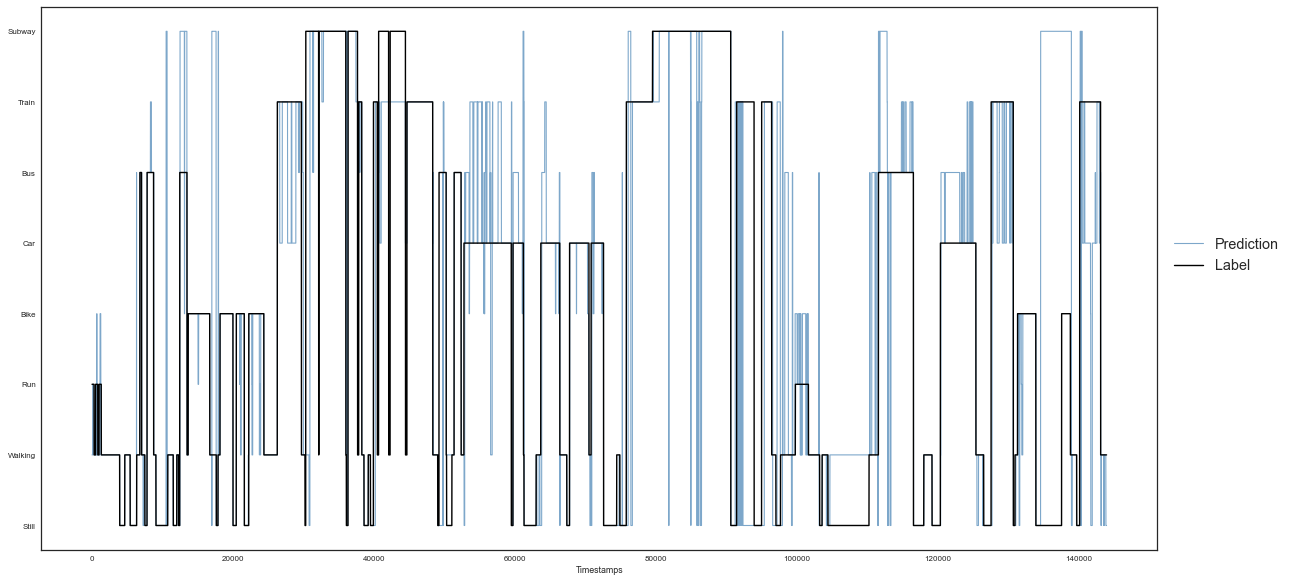

In [123]:
plot_prediction(y_val, pred_mean2)

## Rule-Based Method

- Duration Restriction
- Transition Banning

In [134]:
def get_group_conscount(sr):
    groups = groupby(sr.values.tolist())
    grouped_elements = [list(group) for key, group in groups]
    dur_df = pd.DataFrame({"label": [t[0] for t in grouped_elements],
                        "duration": [len(t) for t in grouped_elements]})
    return dur_df

In [135]:
df_dur = get_group_conscount(pred_mean2)
df_dur['cons_state_index'] = df_dur.index

In [136]:
df_res = pd.DataFrame({'pred': pred_mean2})
df_res['cons_state_index'] = (df_res['pred'].diff(1) != 0).astype('int').cumsum() - 1
df_res = pd.merge(df_res, df_dur, on = 'cons_state_index')

In [137]:
df_res['pred_last'] = df_res['pred'].shift(1).fillna(method = 'bfill').astype('int')

In [138]:
rule_time_dic = dict({1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5})

In [139]:
rule_trans_map = np.array(pd.read_table('data/transition_rule.txt', sep = ',', header = None))

In [140]:
pred_rule = df_res['pred'].copy()
for i in range(df_res.shape[0]):
    if df_res['duration'][i] < rule_time_dic[df_res['pred'][i]]:
        pred_rule[i] = df_res['pred_last'][i]
        df_res['pred_last'][i+1] = pred_rule[i]
    # transition rule
    # if rule_trans_map[df_res['pred_last'][i]-1, df_res['pred'][i]-1] == 0:
    #     pred_rule[i] = df_res['pred_last'][i]
    #     df_res['pred_last'][i+1] = pred_rule[i]

[[19098  6519     0    28    21   154   761  3255]
 [ 3046 19714     6    44   253  1384   694  1008]
 [    0  1151   435  1188     0     0     0     0]
 [  137   585   368  9696     0     0     0  1245]
 [  441   328     0   566 11130  4909  3038    61]
 [  856    28     0    17     0  5046  1114  2117]
 [ 3399    53     0    35  4225   243 13267   586]
 [  383   472     0     0  1982   100  3305 15467]]
              precision    recall  f1-score   support

       Still       0.70      0.64      0.67     29836
     Walking       0.68      0.75      0.72     26149
         Run       0.54      0.16      0.24      2774
        Bike       0.84      0.81      0.82     12031
         Car       0.63      0.54      0.58     20473
         Bus       0.43      0.55      0.48      9178
       Train       0.60      0.61      0.60     21808
      Subway       0.65      0.71      0.68     21709

    accuracy                           0.65    143958
   macro avg       0.63      0.60      0.60    14

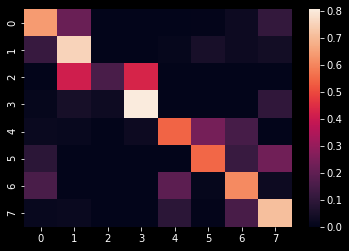

In [141]:
helper.evaluate(y_val, pred_rule)

In [142]:
df_dur2 = get_group_conscount(pred_rule)

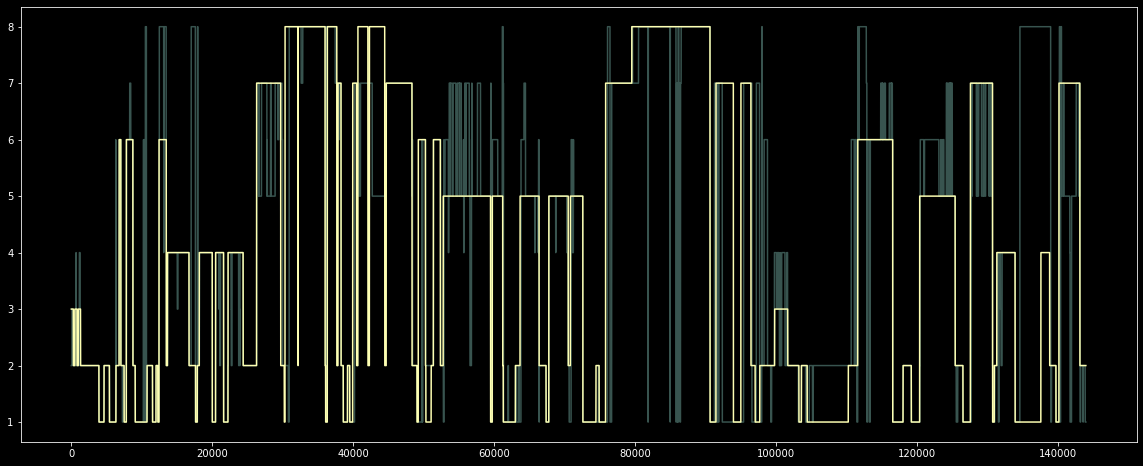

In [144]:
plot_prediction(y_val, pred_rule)

In [145]:
df_dur2.groupby('label').min()

,duration
label,
1,6
2,5
3,5
4,7
5,6
6,7
7,5
8,50


## Transition

In [173]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp

array([[ 0., 23.,  4., 21.,  8., 45., 32., 23.],
       [60.,  0., 12., 21., 15., 15., 16., 22.],
       [ 8., 11.,  0.,  6.,  6.,  3.,  2.,  0.],
       [28., 23.,  5.,  0.,  6.,  2.,  4.,  0.],
       [ 8., 11.,  7.,  8.,  0.,  0.,  0.,  0.],
       [17., 42.,  7.,  2.,  0.,  0.,  0.,  0.],
       [17., 24.,  0.,  9.,  0.,  3.,  0.,  2.],
       [18., 27.,  1.,  0.,  0.,  0.,  1.,  0.]])

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 0 0 0]
 [1 1 1 1 0 1 0 0]
 [1 1 0 1 0 1 1 1]
 [1 1 1 0 0 0 1 1]]


<AxesSubplot:>

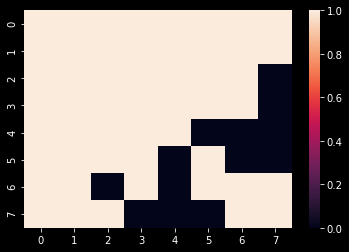

In [215]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp = 1-(tmp == 0).astype('int') + np.diag([1]*8)
print(tmp)
sns.heatmap(tmp)

<AxesSubplot:>

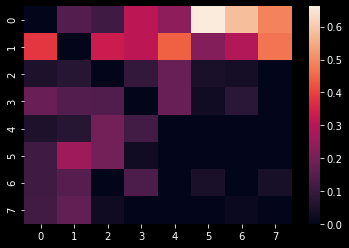

In [146]:
sns.heatmap(tmp / tmp.sum(axis = 1)) # axis = 1 求行和

In [112]:
# plt.figure(figsize = [12, 6])
# sns.boxplot(x = df_dur['label'], y = df_dur['duration'])